In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms as tfs
from torch.utils.data import DataLoader, random_split, Dataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import io
from torchsummary import summary
from tqdm.notebook import tqdm
import os
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
#data = pd.read_csv("/content/gdrive/MyDrive/data_05.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Гиперпараметры


In [ ]:
latent_space = 200 # размер вектора для генератора
batch_size = 2 # размер батчей
dim = 64 # размер количества ячеек по каждой из осей
in_channels = 512 # количество входных слоев
num_workers = 2 # количество потоков обработки dataloader
path_to_datasets = '/content/gdrive/MyDrive/datasets_mofs' 

# Create CustomDataset
Skip if u have dataset

In [ ]:
class CustomDataset(Dataset):
    # This loads the data and converts it, make data rdy
    def __init__(self, path):
      self.d = pd.read_csv(path)
    
    # This returns the total amount of samples in your Dataset
    def __len__(self):
        return len(self.d[['energy']])
    
    # This returns given an index the i-th sample and label
    def __getitem__(self, idx):
        ee_local = np.loadtxt(io.StringIO(self.d.iloc[idx]['energy']))
        ee_work = ee_local.reshape(
           ee_local.shape[0], ee_local.shape[1] // dim, dim)
        ee_ten = torch.from_numpy(ee_work).type(torch.float32).view(1, dim, dim, dim)
        return ee_ten

In [ ]:
def create_dataloader(path):
  ds = CustomDataset(path)
  train_dl = DataLoader(ds, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
  del(ds)
  gc.collect()
  return train_dl

# Visualization

In [ ]:
def save_el(e, folder, max_v_e = 1000, f = 0.2, cmap = 'hot', dpi = 400):  
  e = (e.view(dim, dim*dim)).detach().numpy()
  le = np.clip(e, None, max_v_e)
  le = np.log(-le+f)
  plt.imsave(folder, le, cmap = cmap, dpi = dpi)

# Discriminator

In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self, in_channels=1, dim=64, out_conv_channels=512):
        super(Discriminator, self).__init__()
        conv1_channels = int(out_conv_channels / 8)
        conv2_channels = int(out_conv_channels / 4)
        conv3_channels = int(out_conv_channels / 2)
        self.out_conv_channels = out_conv_channels
        self.out_dim = int(dim / 16)

        self.conv1 = nn.Sequential(
            nn.Conv3d(
                in_channels=in_channels, out_channels=conv1_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv1_channels),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv3d(
                in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv2_channels),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv3d(
                in_channels=conv2_channels, out_channels=conv3_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv3_channels),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv3d(
                in_channels=conv3_channels, out_channels=out_conv_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(out_conv_channels),
            nn.ReLU(inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(out_conv_channels * self.out_dim * self.out_dim * self.out_dim, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Flatten and apply linear + sigmoid
        x = x.view(-1, self.out_conv_channels * self.out_dim * self.out_dim * self.out_dim)
        return self.out(x)

# Generator

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self, in_channels=512, out_dim=64, out_channels=1, noise_dim=200, activation="sigmoid"):
        super(Generator, self).__init__()
        self.in_channels = in_channels
        self.out_dim = out_dim
        self.in_dim = int(out_dim / 16)
        conv1_out_channels = int(self.in_channels / 2.0)
        conv2_out_channels = int(conv1_out_channels / 2)
        conv3_out_channels = int(conv2_out_channels / 2)

        self.linear = torch.nn.Linear(noise_dim, in_channels * self.in_dim * self.in_dim * self.in_dim)

        self.conv1 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=in_channels, out_channels=conv1_out_channels, kernel_size=(4, 4, 4),
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv1_out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=conv1_out_channels, out_channels=conv2_out_channels, kernel_size=(4, 4, 4),
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv2_out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=conv2_out_channels, out_channels=conv3_out_channels, kernel_size=(4, 4, 4),
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv3_out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=conv3_out_channels, out_channels=out_channels, kernel_size=(4, 4, 4),
                stride=2, padding=1, bias=False
            )
        )
        if activation == "sigmoid":
            self.out = torch.nn.Sigmoid()
        else:
            self.out = torch.nn.Tanh()

    def project(self, x):
        """
        projects and reshapes latent vector to starting volume
        :param x: latent vector
        :return: starting volume
        """
        return x.view(-1, self.in_channels, self.in_dim, self.in_dim, self.in_dim)

    def forward(self, x):
        x = self.linear(x)
        x = self.project(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return self.out(x)

# Test model

In [ ]:
generator_t = Generator(in_channels=in_channels, out_dim=dim, out_channels=1, noise_dim=latent_space)
noise = torch.rand(1, latent_space)
generated_volume = generator_t(noise)
print("Generator output shape", generated_volume.shape)
discriminator_t = Discriminator(in_channels=1, dim=dim, out_conv_channels=in_channels)
out = discriminator_t(generated_volume)
print("Discriminator output", out.item())
print("\n\nGenerator summary\n\n")
summary(generator_t, (1, latent_space))
print("\n\nDiscriminator summary\n\n")
summary(discriminator_t, (1,dim,dim,dim))

Generator output shape torch.Size([1, 1, 64, 64, 64])
Discriminator output 0.4398098289966583


Generator summary


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1, 32768]       6,586,368
   ConvTranspose3d-2         [-1, 256, 8, 8, 8]       8,388,608
       BatchNorm3d-3         [-1, 256, 8, 8, 8]             512
              ReLU-4         [-1, 256, 8, 8, 8]               0
   ConvTranspose3d-5      [-1, 128, 16, 16, 16]       2,097,152
       BatchNorm3d-6      [-1, 128, 16, 16, 16]             256
              ReLU-7      [-1, 128, 16, 16, 16]               0
   ConvTranspose3d-8       [-1, 64, 32, 32, 32]         524,288
       BatchNorm3d-9       [-1, 64, 32, 32, 32]             128
             ReLU-10       [-1, 64, 32, 32, 32]               0
  ConvTranspose3d-11        [-1, 1, 64, 64, 64]           4,096
          Sigmoid-12        [-1, 1, 64, 64, 64]    

# Fit model



---



In [ ]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    losses_g_datasets = []
    losses_d_datasets = []
    real_scores_datasets = []
    fake_scores_datasets = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        print(f"\n\nEpoch [{epoch + 1}/{epochs}]")
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        datasets = next(os.walk(path_to_datasets))
        for c, dataset in enumerate(datasets[2]):
          print(f"\nDis Dataset [{c+1}/{len(datasets[2])}] Epoch [{epoch + 1}/{epochs}]")
          loss_d_per_dataset = []
          loss_g_per_dataset = []
          real_score_per_dataset = []
          fake_score_per_dataset = []
          train_dl = create_dataloader(path_to_datasets + '/' + dataset)
          for real_mof in tqdm(train_dl):
              # Train discriminator
              # Clear discriminator gradients
              optimizer["discriminator"].zero_grad()

              # Pass real mof through discriminator
              real_preds = model["discriminator"](real_mof)
              real_targets = torch.ones(real_mof.size(0), 1)
              real_loss = criterion["discriminator"](real_preds, real_targets)
              cur_real_score = torch.mean(real_preds).item()
              
              # Generate fake mof from latent space
              latent = torch.randn(batch_size, latent_space)
              fake_mof = model["generator"](latent)

              # Pass fake mof through discriminator
              fake_targets = torch.zeros(fake_mof.size(0), 1)
              fake_preds = model["discriminator"](fake_mof)
              fake_loss = criterion["discriminator"](fake_preds, fake_targets)
              cur_fake_score = torch.mean(fake_preds).item()

              real_score_per_dataset.append(cur_real_score)
              fake_score_per_dataset.append(cur_fake_score)

              # Update discriminator weights
              loss_d = real_loss + fake_loss
              loss_d.backward()
              optimizer["discriminator"].step()
              loss_d_per_dataset.append(loss_d.item())
          del(train_dl)
          gc.collect()
          # Record losses & scores per dataset
          loss_d_per_epoch.append(np.mean(loss_d_per_dataset))
          real_score_per_epoch.append(np.mean(real_score_per_dataset))
          fake_score_per_epoch.append(np.mean(fake_score_per_dataset))

          # Record all losses & scores per datasets
          losses_d_datasets.append(np.mean(loss_d_per_dataset))
          real_scores_datasets.append(np.mean(real_scores_datasets))
          fake_scores_datasets.append(np.mean(fake_score_per_dataset))

          # Log losses & scores (last dataset)
          print(f"Dis Dataset [{c+1}/{len(datasets[2])}]  Epoch [{epoch + 1}/{epochs}], loss_d: {loss_d_per_epoch[-1]}, real_score: {real_score_per_epoch[-1]}, fake_score: {fake_score_per_epoch[-1]}")


        for c, dataset in enumerate(datasets[2]):
          print(f"\nGen Dataset [{c+1}/{len(datasets[2])}] Epoch [{epoch + 1}/{epochs}]")
          loss_d_per_dataset = []
          loss_g_per_dataset = []
          real_score_per_dataset = []
          fake_score_per_dataset = []
          train_dl = create_dataloader(path_to_datasets + '/' + dataset)
          for real_mof in tqdm(train_dl):
              # Train generator
              # Clear generator gradients
              optimizer["generator"].zero_grad()
              
              # Generate fake mof
              latent = torch.randn(batch_size, latent_space)
              fake_mof = model["generator"](latent)
              
              # Try to fool the discriminator
              preds = model["discriminator"](fake_mof)
              targets = torch.ones(batch_size, 1)
              loss_g = criterion["generator"](preds, targets)
              
              # Update generator weights
              loss_g.backward()
              optimizer["generator"].step()
              loss_g_per_dataset.append(loss_g.item())
          del(train_dl)
          gc.collect()
          # Record losses & scores per dataset
          loss_g_per_epoch.append(np.mean(loss_g_per_dataset))

          # Record all losses & scores per datasets
          losses_g_datasets.append(np.mean(loss_g_per_dataset))

          # Log losses & scores (last dataset)
          print(f"Gen Dataset [{c+1}/{len(datasets[2])}]  Epoch [{epoch + 1}/{epochs}], loss_g: {loss_g_per_epoch[-1]}")
              
        # Record losses & scores per epoch
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
    return losses_g, losses_d, real_scores, fake_scores, losses_g_datasets, losses_d_datasets, real_scores_datasets, fake_scores_datasets

init gen & dis

In [ ]:
generator = Generator(in_channels=in_channels, out_dim=dim, out_channels=1, noise_dim=latent_space)
discriminator = Discriminator(in_channels=1, dim=dim, out_conv_channels=in_channels)

init gan model & crit

In [ ]:
model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.MSELoss(),
    "generator": nn.MSELoss()
}
lr = 0.0002
epochs = 3

fit the model

In [ ]:
history = fit(model, criterion, epochs, lr)



Epoch [1/3]

Dataset [1/7] Epoch [1/3]


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dataset [1/7]  Epoch [1/3], loss_g: 0.9896821022033692, loss_d: 0.15003107124704795, real_score: 0.8118928660452366, fake_score: 0.042531887013590224

Dataset [2/7] Epoch [1/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset [2/7]  Epoch [1/3], loss_g: 0.9981353604793548, loss_d: 0.0018181651023694634, real_score: 0.9861227738857269, fake_score: 0.004001880395078388

Dataset [3/7] Epoch [1/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset [3/7]  Epoch [1/3], loss_g: 0.9998804152011871, loss_d: 0.0018580249277915083, real_score: 0.9920554006099701, fake_score: 5.1373424882399376e-05

Dataset [4/7] Epoch [1/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset [4/7]  Epoch [1/3], loss_g: 0.9991316735744477, loss_d: 0.0003041108464602393, real_score: 0.9963193845748901, fake_score: 0.002028059120901844

Dataset [5/7] Epoch [1/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset [5/7]  Epoch [1/3], loss_g: 0.9999966859817505, loss_d: 5.928003320338604e-05, real_score: 0.9974438858032226, fake_score: 1.6303390441407829e-06

Dataset [6/7] Epoch [1/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset [6/7]  Epoch [1/3], loss_g: 0.9999959969520569, loss_d: 3.6378409915105436e-05, real_score: 0.998363755941391, fake_score: 2.2792583365571774e-06

Dataset [7/7] Epoch [1/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset [7/7]  Epoch [1/3], loss_g: 0.9999943208694458, loss_d: 5.785889918405118e-05, real_score: 0.9970349073410034, fake_score: 2.8563182581820003e-06
Epoch [1/3], loss_g: 0.9981, loss_d: 0.0220, real_score: 0.9685, fake_score: 0.0069


Epoch [2/3]

Dataset [1/7] Epoch [2/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset [1/7]  Epoch [2/3], loss_g: 0.9999945938587189, loss_d: 8.205769387385643e-06, real_score: 0.9988670074939727, fake_score: 3.0052058468754694e-06

Dataset [2/7] Epoch [2/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset [2/7]  Epoch [2/3], loss_g: 0.9999933230876923, loss_d: 7.0070856274861985e-06, real_score: 0.9988965392112732, fake_score: 3.110204620497825e-06

Dataset [3/7] Epoch [2/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset [3/7]  Epoch [2/3], loss_g: 0.9999922978878021, loss_d: 3.787940306199111e-05, real_score: 0.9975143885612487, fake_score: 3.700394697716547e-06

Dataset [4/7] Epoch [2/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset [4/7]  Epoch [2/3], loss_g: 0.9999915742874146, loss_d: 3.3197290767963405e-05, real_score: 0.9975228691101075, fake_score: 3.8005777651051174e-06

Dataset [5/7] Epoch [2/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset [5/7]  Epoch [2/3], loss_g: 0.9999908602237702, loss_d: 1.3578816521511162e-05, real_score: 0.9985516119003296, fake_score: 4.640071711037308e-06

Dataset [6/7] Epoch [2/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset [6/7]  Epoch [2/3], loss_g: 0.9999885857105255, loss_d: 1.0598000330173662e-05, real_score: 0.9988015532493592, fake_score: 5.332701234692649e-06

Dataset [7/7] Epoch [2/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset [7/7]  Epoch [2/3], loss_g: 0.9999885022640228, loss_d: 1.2812607896682814e-05, real_score: 0.9985206341743469, fake_score: 1.1843437671359424e-05
Epoch [2/3], loss_g: 1.0000, loss_d: 0.0000, real_score: 0.9984, fake_score: 0.0000


Epoch [3/3]

Dataset [1/7] Epoch [3/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset [1/7]  Epoch [3/3], loss_g: 0.9999789464473724, loss_d: 5.914434275007263e-06, real_score: 0.9989902281761169, fake_score: 7.75097241785261e-06

Dataset [2/7] Epoch [3/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset [2/7]  Epoch [3/3], loss_g: 0.9999614608287811, loss_d: 5.467773864458181e-06, real_score: 0.9990446865558624, fake_score: 1.8132032555513432e-05

Dataset [3/7] Epoch [3/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset [3/7]  Epoch [3/3], loss_g: 0.9999212777614593, loss_d: 6.2023712688286105e-06, real_score: 0.9989965879917144, fake_score: 7.211419724626467e-05

Dataset [4/7] Epoch [3/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset [4/7]  Epoch [3/3], loss_g: 0.917509383065626, loss_d: 0.19925083370738494, real_score: 0.8961983116923216, fake_score: 0.12418319507434575

Dataset [5/7] Epoch [3/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset [5/7]  Epoch [3/3], loss_g: 0.9940711641311646, loss_d: 0.009912979010049502, real_score: 0.9968539130687714, fake_score: 0.010156875969932627

Dataset [6/7] Epoch [3/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset [6/7]  Epoch [3/3], loss_g: 0.9900573074817658, loss_d: 0.0021693767484614853, real_score: 0.994294729232788, fake_score: 0.003052425989877112

Dataset [7/7] Epoch [3/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset [7/7]  Epoch [3/3], loss_g: 0.9356072282445211, loss_d: 0.07698712503763508, real_score: 0.9890219533443451, fake_score: 0.07629219929807195
Epoch [3/3], loss_g: 0.9767, loss_d: 0.0412, real_score: 0.9819, fake_score: 0.0305


# Save Generated image

In [ ]:
losses_g, losses_d, real_scores, fake_scores, losses_g_datasets, losses_d_datasets, real_scores_datasets, fake_scores_datasets = history_2

In [ ]:
l = torch.randn(latent_space)

In [ ]:
g = generator_2(l)

In [ ]:
g.min()

tensor(0.0003, grad_fn=<MinBackward1>)

In [ ]:
save_el(g, "after_7.png", f=1)

# Show losses & scores

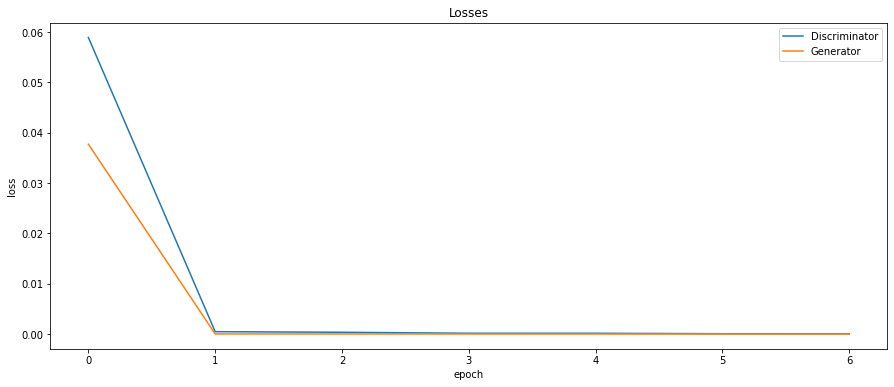

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d_datasets, '-')
plt.plot(losses_g_datasets, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

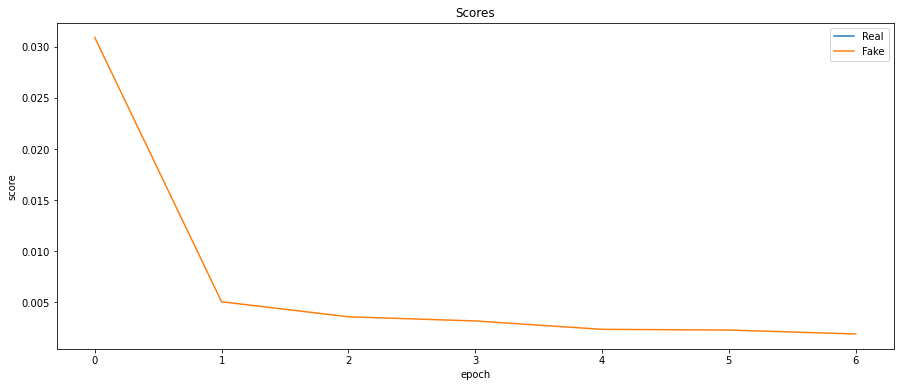

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores_datasets, '-')
plt.plot(fake_scores_datasets, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');